In [1]:
root_dir = '/data/ChaochaoData/DSA-DL/HyperMorph/'
workspace = root_dir + 'Comparison/'
util_dir = '/data/ChaochaoData/DSA-DL/Utilities/'
train_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTrain'
test_dir = '/data/ChaochaoData/PixShift/DataSets/PaperData/CombinedTest'
cm_train_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/train_dataset'
cm_test_dir = '/data/ChaochaoData/ClearMatch/nifti_predictions/test_dataset'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
# plt.rcParams['animation.ffmpeg_path'] = '/usr/local/lib/python3.8/dist-packages'
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import neurite as ne
import voxelmorph as vxm
import tensorflow as tf

import os, sys, shutil
import nibabel as nib
import cv2
# from scipy import ndimage
# from IPython import display  # Would conflict with Python's display
import IPython
import logging
import warnings

sys.path.insert(0, util_dir)
from utils import *
# from paper_visualization import *

warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.experimental.output_all_intermediates(True)
tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

2024-01-02 23:52:05.500389: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading BokehJS ...

In [3]:
folders_train_old = [os.path.join(train_dir, f) for f in sorted(os.listdir(train_dir))
                     if not os.path.isfile(os.path.join(train_dir, f))]
folders_test_old = [os.path.join(test_dir, f) for f in sorted(os.listdir(test_dir))
                    if not os.path.isfile(os.path.join(test_dir, f))]
print(len(folders_train_old), len(folders_test_old))

folders_train_cm = [os.path.join(cm_train_dir, f) for f in sorted(os.listdir(cm_train_dir))
                    if not os.path.isfile(os.path.join(cm_train_dir, f))]
folders_test_cm = [os.path.join(cm_test_dir, f) for f in sorted(os.listdir(cm_test_dir))
                   if not os.path.isfile(os.path.join(cm_test_dir, f))]
print(len(folders_train_cm), len(folders_test_cm))

folders_train = folders_train_old + folders_train_cm
folders_test = folders_test_old + folders_test_cm

print(len(folders_train), len(folders_test))

folders_sel = folders_test

4946 100
100 94
5046 194


In [4]:
# model_names = ['Naive', 'MinMax', 'MeanMask', 'FilMask', 'ProbMatte']
image_shape = (512, 512)

def init_hpnet(hp_input):
    x = tf.keras.layers.Dense(32, activation='relu')(hp_input)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    hypernetwork = tf.keras.Model(hp_input, x, name='hypernetwork')
    return hypernetwork

def load_model(model_name):
    if model_name is 'Naive':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'Naive/dsa-hyper-naive.h5')
        model.load_weights(model_path)    
    elif model_name is 'MinMax':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, bidir=True, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'MinMax/dsa_hyper_cycle.h5')
        model.load_weights(model_path)
    elif model_name is 'MeanMask':
        hp_input = tf.keras.Input(shape=[2])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'LayerSep-mean-thresh/dsa-hyper-ls.h5')
        model.load_weights(model_path)
    elif model_name is 'FilMask':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'LayerSep-filter/dsa-hyper-ls.h5')
        model.load_weights(model_path)        
    elif model_name is 'ProbMatte':
        hp_input = tf.keras.Input(shape=[1])
        hypernetwork = init_hpnet(hp_input)
        model = vxm.networks.VxmDense(image_shape, int_steps=0, hyp_model=hypernetwork)
        model_path = os.path.join(root_dir, 'LayerSep-prob/dsa-hyper-ls.h5')
        model.load_weights(model_path)
    # print(os.path.exists(model_path))
    return model

In [5]:
def flow_predict(model_name, xseq_bg, xseq_ct):
    if model_name is 'Naive':
        hp = [0.7]    
    elif model_name is 'MinMax':
        hp = [0.5]
    elif model_name is 'MeanMask':
        hp = [0.7, 0]
    elif model_name is 'FilMask':
        hp = [0.7]        
    elif model_name is 'ProbMatte':
        hp = [0.7]
    
    nx = len(xseq_bg)
    hp_seq = np.repeat(np.array([hp]), nx, axis=0)
    inputs = [xseq_bg, xseq_ct, hp_seq]
    
    model = models[model_name]
    preds = model.predict(inputs, verbose=0) 
    flow = preds[-1]    
    
    return flow

In [6]:
def out_flow_cases(xrays):    
    idx_f0 = 0
    nx = xrays.shape[0]
    
    xseq_bg = np.repeat(xrays[idx_f0][None], nx, axis=0)
    xseq_ct = xrays
    
    zero_flow = np.zeros([nx, *image_shape, 2], dtype='float32')
    flow_cases = [zero_flow]  
    
    for model_name in models.keys():
        flow = flow_predict(model_name, xseq_bg, xseq_ct)  
        flow_cases.append(flow)
    
    return flow_cases

## Output test samples 

In [7]:
models = {
    'Naive': load_model('Naive'),
    'MinMax': load_model('MinMax'),
    'FilMask': load_model('FilMask')
}

2024-01-02 23:52:32.808755: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 23:52:35.225911: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2024-01-02 23:52:35.227878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45570 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2024-01-02 23:52:35.330324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [9]:
seq_name = '80'.zfill(3)

dst_dir = os.path.join(workspace, 'test_samples', seq_name)
with open(os.path.join(dst_dir, "pool_order.txt"), "r") as file:
    pool_order = [int(line) for line in file.readlines()]

# with open(os.path.join(dst_dir, "src_dir.txt"), "r") as file:
#     src_dir = file.readline()

xrays = load_xray_seq(folders_sel, int(seq_name))
flow_cases = out_flow_cases(xrays)

2024-01-02 23:54:21.136447: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-02 23:54:21.933193: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


[1, 2, 0, 3]


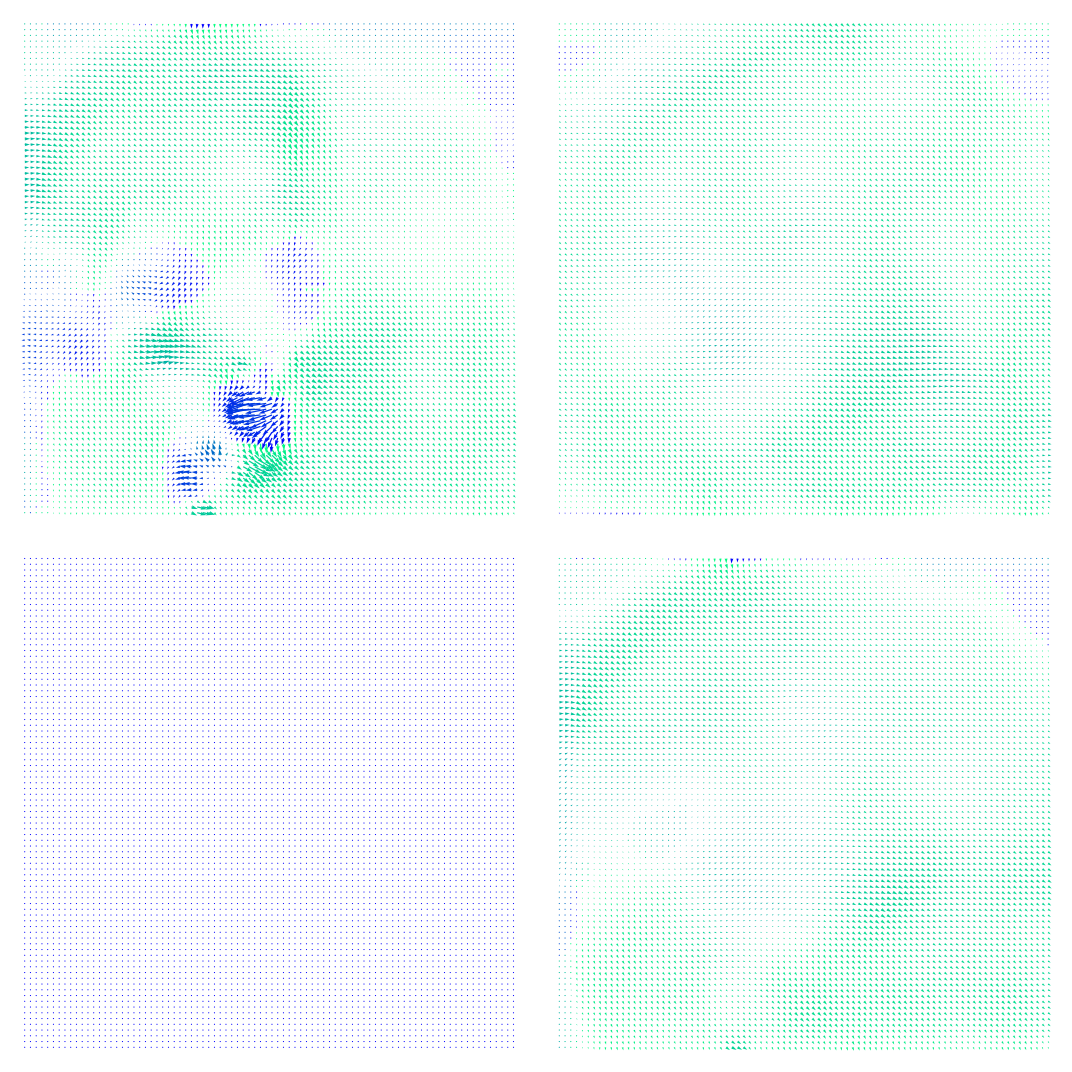

In [10]:
idx_frame = 8

print(pool_order)
flows = [flow_cases[pool_order[i]][idx_frame, ::6, ::6, :] for i in range(len(pool_order))]
ne.plot.flow(flows, grid=True);